### Gerekli Kütüphanelerin yüklenmesi

### UYGULAMA BAŞLANGICI
Gerekli paketlerin yüklenmesi...

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.layers import Dense, Conv2D, Activation, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint

2025-02-05 13:10:32.586649: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738750232.606646    9454 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738750232.612228    9454 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-05 13:10:32.631550: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Veri setinin okunması

In [2]:
import os
root = '/home/dilaver/Keras_ile_Derin_Ogrenme'

os.chdir(root)
!ls -l

total 619448
-rw-r--r-- 1 dilaver dilaver     21007 Feb  3 13:09 01-Keras_Minst.ipynb
-rw-r--r-- 1 dilaver dilaver     15011 Feb  3 13:06 02-Kaydedilmis_Modelden_Tahmin.ipynb
-rw-r--r-- 1 dilaver dilaver    471470 Feb  3 13:06 03-Aktivasyon_Fonksiyonlari.ipynb
-rw-r--r-- 1 dilaver dilaver     32826 Feb  3 13:06 04-Evrisimli_Sinir_Agi_Modelleme.ipynb
-rw-r--r-- 1 dilaver dilaver    105771 Feb  3 13:06 05-Rakam_Tanima.ipynb
-rw-r--r-- 1 dilaver dilaver    114915 Feb  3 13:06 06-FASHION_MNIST.ipynb
-rw-r--r-- 1 dilaver dilaver    356734 Feb  3 13:06 07-FASHIONMNIST_Tahmin.ipynb
-rw-r--r-- 1 dilaver dilaver    117594 Feb  3 13:06 08-IMAGENET-VGG16-ile-NESNE_TANIMA.ipynb
-rw-r--r-- 1 dilaver dilaver    882065 Feb  3 13:21 09-IMAGENET-ResNet50-ile-NESNE_TANIMA.ipynb
-rw-r--r-- 1 dilaver dilaver    148829 Feb  5 13:09 10-DUYGU_TANIMA.ipynb
-rw-r--r-- 1 dilaver dilaver     50392 Feb  3 15:46 Model_Gorseli.png
-rw-r--r-- 1 dilaver dilaver         0 Feb  3 15:47 Model_Görseli.png:Zone.Identifier

In [3]:
data = pd.read_csv(root + "/fer2013.csv")
data.shape

(35887, 3)

In [4]:
# Verinin bir kısmını görelim
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [5]:
data["Usage"].value_counts()

Usage
Training       28709
PublicTest      3589
PrivateTest     3589
Name: count, dtype: int64

**Usage** kolonunda verisetindeki örnekler kaç gruba ayrıldığını görebiliriz. <span style="color:blue">Kaggle</span>da genelde bu şekilde submit sonrası asıl test edilmesi için verisetinden bir kısmını **"PrivateTest"** olarak ayırırlar.

## EĞİTİM VERİSİ İÇİN ÖN İŞLEME ADIMLARI

In [6]:
np.unique(data["Usage"].values.ravel())
print("Eğitim setindeki örnek sayısı : %d"%(len(data[data.Usage =="Training"])))
print("Eğitim setindeki PrivateTest sayısı : %d"%(len(data[data.Usage =="PrivateTest"])))
print("Eğitim setindeki PublicTest sayısı : %d"%(len(data[data.Usage =="PublicTest"])))

Eğitim setindeki örnek sayısı : 28709
Eğitim setindeki PrivateTest sayısı : 3589
Eğitim setindeki PublicTest sayısı : 3589


### Eğitim işlemi için veri kümesinde ayrılmış olan **Training** kısmını alıyoruz

In [7]:
train_data = data[data.Usage == "Training"] # Sadece eğitim örneklerini train_data içine aldık.

In [8]:
# İçi içe listelerdeki string verileri int'e dönüştürme fonksiyonu
def convert_str_to_int(nested_list):
    for i in range(len(nested_list)):
        if isinstance(nested_list[i], list):  # Eğer öğe bir liste ise
            nested_list[i] = convert_str_to_int(nested_list[i])  # Rekürsif olarak iç listeyi dönüştür
        elif isinstance(nested_list[i], str):  # Eğer öğe bir string ise
            try:
                nested_list[i] = int(nested_list[i])  # String'i int'e dönüştür
            except ValueError:
                pass  # Eğer dönüşüm başarısızsa, değişiklik yapma
    return nested_list

In [9]:
# Örnek iç içe liste
nested_list = [['1', '2', '3'], ['4', '5'], ['6', '7', '8']]
print("Orijinal Liste:", nested_list)

# String değerleri integer'a dönüştürme
converted_list = convert_str_to_int(nested_list)
print("Dönüştürülmüş Liste:", converted_list)

Orijinal Liste: [['1', '2', '3'], ['4', '5'], ['6', '7', '8']]
Dönüştürülmüş Liste: [[1, 2, 3], [4, 5], [6, 7, 8]]


**Eğitim örneklerinin piksel değerleri bize tablo halinde yan yana verildiği için boşluklardan parse ederek liste olarak değişkene alalım.**

In [10]:
# 'pixels' sütunundaki verileri listeye dönüştür
train_pixels = train_data.pixels.str.split(" ").tolist()

train_pixels = convert_str_to_int(train_pixels)
train_pixels = pd.DataFrame(train_pixels, dtype=int)
train_images = train_pixels.values
train_images = train_images.astype(np.float16)

print(train_images)
print(train_images.shape)

[[ 70.  80.  82. ... 106. 109.  82.]
 [151. 150. 147. ... 193. 183. 184.]
 [231. 212. 156. ...  88. 110. 152.]
 ...
 [ 74.  81.  87. ... 188. 187. 187.]
 [222. 227. 203. ... 136. 136. 134.]
 [195. 199. 205. ...   6.  15.  38.]]
(28709, 2304)


In [11]:
#Görüntüyü 48x48 piksel şeklinde göstermek için fonksiyon tanımlama
def show(img):
    show_image = img.reshape(48, 48)

    plt.axis('off')
    plt.imshow(show_image, cmap="gray")

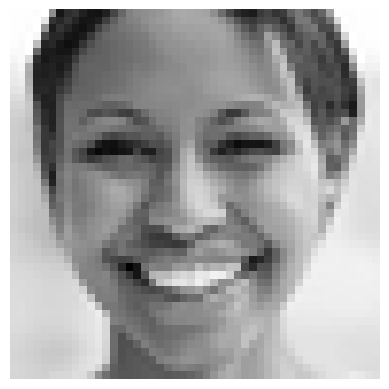

In [12]:
# Veri kümesinden 
show(train_images[445])

**Eğitim kümesinde kaç sınıf bulunuyor bunu görelim**

In [13]:
train_label_flat = train_data["emotion"].values.ravel()
train_labels_count = np.unique(train_label_flat).shape[0]
print("Farklı yüz ifadelerinin sayısı: %d"%train_labels_count)

Farklı yüz ifadelerinin sayısı: 7


**One Hot ile eğitim kümesindeki verilerin her birine düşen sınıfı yani eğitim işlemi boyutunu görelim.**

In [14]:
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

In [15]:
y_train = dense_to_one_hot(train_label_flat, train_labels_count)
y_train = y_train.astype(np.uint8)
print(y_train.shape)

(28709, 7)


## TEST VERİSİ ÖN İŞLEME ADIMLARI

In [16]:
np.unique(data["Usage"].values.ravel())
print("Eğitim setindeki PublicTest sayısı : %d"%(len(data[data.Usage =="PublicTest"])))

Eğitim setindeki PublicTest sayısı : 3589


### Eğitim işlemi için veri kümesinde ayrılmış olan **PublicTest** kısmını alıyoruz.

In [17]:
test_data = data[data.Usage == "PublicTest"] # Sadece eğitim örneklerini train_data içine aldık.
#Test örneklerinin piksel değerleri bize tablo halinde yan yana verildiği için boşluklardan parse ederek liste olarak değişkene aldık
test_pixels = test_data.pixels.str.split(" ").tolist() 

test_pixels = convert_str_to_int(test_pixels)
test_pixels = pd.DataFrame(test_pixels, dtype=int)
test_images = test_pixels.values
test_images = test_images.astype(np.float16)

#print(test_images)

print(test_images.shape)

# test örneklerinin piksel değerleri bize tablo halinde yan yana verildiği için 
# boşluklardan parse ederek liste olarak değişkene aldık

(3589, 2304)


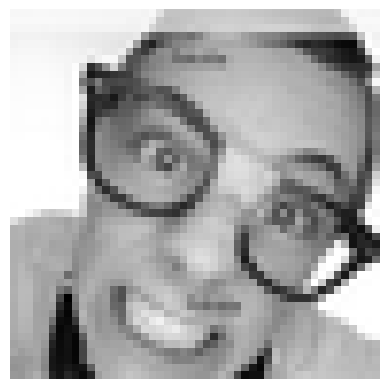

In [18]:
show(test_images[890])

**One Hot ile test kümesindeki verilerin her birine düşen sınıfı yani eğitim işlemi boyutunu görelim.**

In [19]:
test_labels_flat = test_data["emotion"].values.ravel()
test_labels_count = np.unique(test_labels_flat).shape[0]

y_test = dense_to_one_hot(test_labels_flat, test_labels_count)

y_test = y_test.astype(np.uint8)
print(y_test.shape)

(3589, 7)


### TEST KÜMESİNDEN ÖRNEK GÖRÜNTÜLER

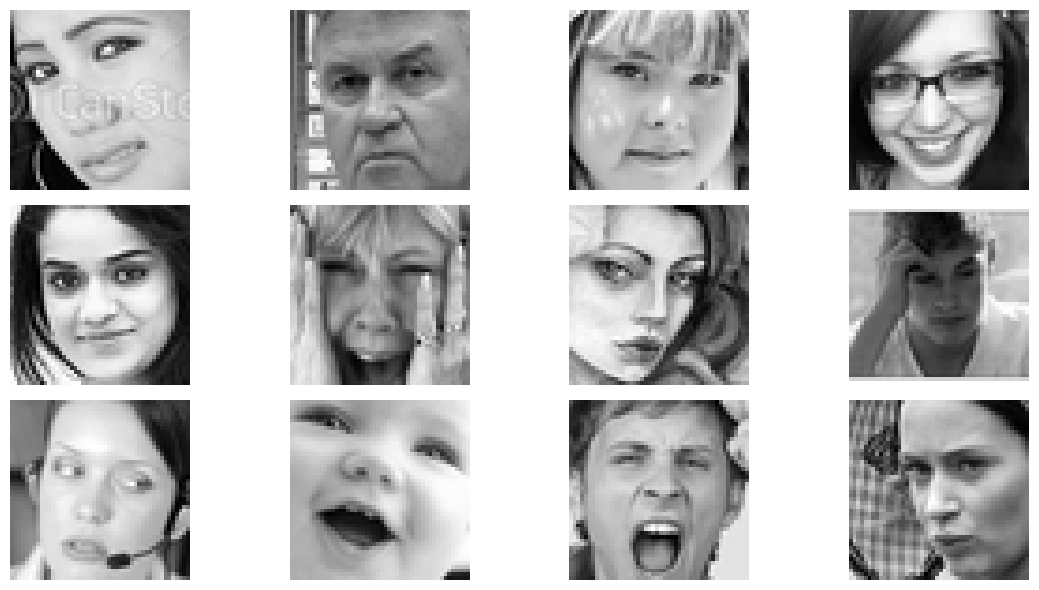

In [20]:
plt.figure(0, figsize=(12,6))
for i in range (1,13):
    plt.subplot(3,4, i)
    plt.axis("off")

    image = test_images[i].reshape(48,48)
    plt.imshow(image, cmap="gray")

plt.tight_layout()
plt.show()

## DERİN EVRİŞİMLİ SİNİR AĞI MODELİ TANIMLANMASI

**Kullandığımız modeli Göreselleştirirsek :**
![Model](http://localhost:8888/files/Keras_ile_Derin_Ogrenme/Model_Gorseli.png?_xsrf=2%7C0bdc9822%7C5145e3bb72535dd692d20e4114767785%7C1738577067)

**Görseldeki modeli yazalım :**

In [21]:
model = Sequential()

#1. Katman :
model.add(Conv2D(64,3, data_format="channels_last", kernel_initializer="he_normal", input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Activation("relu"))

#2. Katman :
model.add(Conv2D(64,3))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2,2), strides=2))
model.add(Dropout(0.6))

#3. Katman :
model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation("relu"))

#4. Katman :
model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation("relu"))


#5. Katman :
model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2,2), strides=2))
model.add(Dropout(0.6))


#TAM BAĞLANTI KATMANI
model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.6))


#Çıkış KATMANI
model.add(Dense(7))
model.add(Activation("softmax"))

model.compile(loss = "categorical_crossentropy",
              optimizer = "adam",
              metrics = ['accuracy'])#opmizasyon ve başarım hesaplama metriklerinin belirlenmesi

#model özetini görselleştirelim
model.summary()

/home/dilaver/tf_env/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1738750276.276129    9454 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6634 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1
I0000 00:00:1738750276.281114    9454 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 6634 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1070, pci bus id: 0000:02:00.0, compute capability: 6.1


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 46, 46, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 44, 44, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 44, 44, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 44, 44, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 20, 20, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 20, 20, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 18, 18, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 18, 18, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 339,111 (1.29 MB)

 Trainable params: 338,407 (1.29 MB)

 Non-trainable params: 704 (2.75 KB)

**Eğtim ve Test kümelerinin eleman sayısı, yükseklik ve genişlik, kanalsayısı bilgilerini ekrana yazdıralım.**

In [22]:
x_train = train_images.reshape(-1, 48, 48, 1)
x_test = test_images.reshape(-1, 48, 48, 1)

print("Train : ", x_train.shape)
print("Test :", x_test.shape)

Train :  (28709, 48, 48, 1)
Test : (3589, 48, 48, 1)


**Eğitim ve Test kümelerinin eleman ve duygu sınıf sayısı.**

In [23]:
print('Train:', y_train.shape)
print('Test:', y_test.shape)

Train: (28709, 7)
Test: (3589, 7)


**Eğitim işleminin gerçekleşmesini istediğimiz epoch, batchsize gibi değerlerin belirlenmesi ve eğitim sonucunda ağırlıkların .keras dosyası olarak kaydedilmesi işlemleri**

In [24]:
#En başarılı ağırlıkları kaydet

checkpointer = ModelCheckpoint(filepath= root + '/face_model.keras', verbose=1, save_best_only=True)

epochs = 20
batchSize = 100

# Modeli çalıştırma
hist = model.fit(x_train, y_train,
                 epochs=epochs,
                 shuffle=True,
                 batch_size=batchSize,
                 validation_data=(x_test, y_test),
                 callbacks=[checkpointer], verbose=2)

model_json = model.to_json()
with open(root+'face_model_keras.json', "w") as json_file:
    json_file.write(model_json)

Epoch 1/20


I0000 00:00:1738750282.979589    9545 service.cc:148] XLA service 0x7f5934002e60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738750282.979640    9545 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1070, Compute Capability 6.1
I0000 00:00:1738750282.979645    9545 service.cc:156]   StreamExecutor device (1): NVIDIA GeForce GTX 1070, Compute Capability 6.1
2025-02-05 13:11:23.073773: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1738750283.539993    9545 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-02-05 13:11:24.249055: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[100,64,44,44]{3,2,1,0}, u8[0]{0}) custom-call(f32[100,64,46,46]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3}, dim_lab


Epoch 1: val_loss improved from inf to 1.59186, saving model to /home/dilaver/Keras_ile_Derin_Ogrenme/face_model.keras
288/288 - 24s - 83ms/step - accuracy: 0.2585 - loss: 1.9909 - val_accuracy: 0.3870 - val_loss: 1.5919
Epoch 2/20

Epoch 2: val_loss improved from 1.59186 to 1.46616, saving model to /home/dilaver/Keras_ile_Derin_Ogrenme/face_model.keras
288/288 - 7s - 24ms/step - accuracy: 0.3594 - loss: 1.6244 - val_accuracy: 0.4400 - val_loss: 1.4662
Epoch 3/20

Epoch 3: val_loss improved from 1.46616 to 1.42174, saving model to /home/dilaver/Keras_ile_Derin_Ogrenme/face_model.keras
288/288 - 7s - 25ms/step - accuracy: 0.4098 - loss: 1.5184 - val_accuracy: 0.4400 - val_loss: 1.4217
Epoch 4/20

Epoch 4: val_loss improved from 1.42174 to 1.36688, saving model to /home/dilaver/Keras_ile_Derin_Ogrenme/face_model.keras
288/288 - 7s - 25ms/step - accuracy: 0.4399 - loss: 1.4481 - val_accuracy: 0.4661 - val_loss: 1.3669
Epoch 5/20

Epoch 5: val_loss improved from 1.36688 to 1.31752, saving

#### Eğitim sonucu elde edilen Eğitim ve Geçerleme (Validation) sonuçlarının grafiksel olarak ifade edilip ekrarna yazdırılması işlemleri.

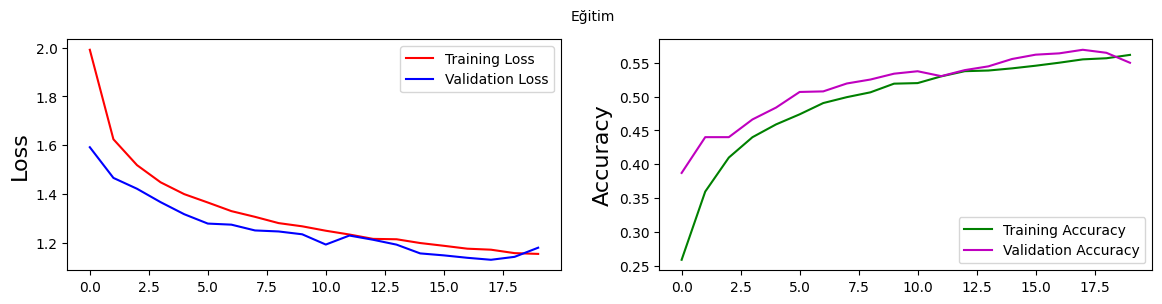

In [25]:
plt.figure(figsize=(14,3))
plt.subplot(1, 2, 1)
plt.suptitle('Eğitim', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist.history['loss'], color ='r', label='Training Loss')
plt.plot(hist.history['val_loss'], color ='b', label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(hist.history['accuracy'], color ='g', label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], color ='m', label='Validation Accuracy')
plt.legend(loc='lower right')

plt.show()

##### Kaggle submit edecek gibi **PrivateTest** örnekleri ile test edelim.

In [26]:
test = data[["emotion", "pixels"]][data["Usage"] == "PrivateTest"]
test["pixels"] = test["pixels"].apply(lambda im: np.fromstring(im, sep=' '))

test.head()

,emotion,pixels
32298,0,"[170.0, 118.0, 101.0, 88.0, 88.0, 75.0, 78.0, ..."
32299,5,"[7.0, 5.0, 8.0, 6.0, 7.0, 3.0, 2.0, 6.0, 5.0, ..."
32300,6,"[232.0, 240.0, 241.0, 239.0, 237.0, 235.0, 246..."
32301,4,"[200.0, 197.0, 149.0, 139.0, 156.0, 89.0, 111...."
32302,2,"[40.0, 28.0, 33.0, 56.0, 45.0, 33.0, 31.0, 78...."


In [27]:
x_test_private = np.vstack(test["pixels"].values)
y_test_private = np.array(test["emotion"])

In [28]:
x_test_private = x_test_private.reshape(-1, 48, 48, 1)
y_test_private = np_utils.to_categorical(y_test_private)
x_test_private.shape, y_test_private.shape

((3589, 48, 48, 1), (3589, 7))

In [29]:
score = model.evaluate(x_test_private, y_test_private, verbose=0)
print("PrivateTest üzerindeki doğruluk durumu:", score)

2025-02-05 13:13:53.297080: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[32,64,44,44]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,46,46]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-02-05 13:13:53.463175: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[32,32,20,20]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,22,22]{3,2,1,0}, f32[32,64,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_

PrivateTest üzerindeki doğruluk durumu: [1.176150918006897, 0.5533574819564819]


**Veri kümseindeki eğitim kısmı ile modeli eğitip test için ayırılan veri ile test işlemlerini yaptık.**

___

### Farklı görüntülerle test işlemlerini yapıp sonuçları görselleştirelim.